Creating a GIF file containing two images and their difference

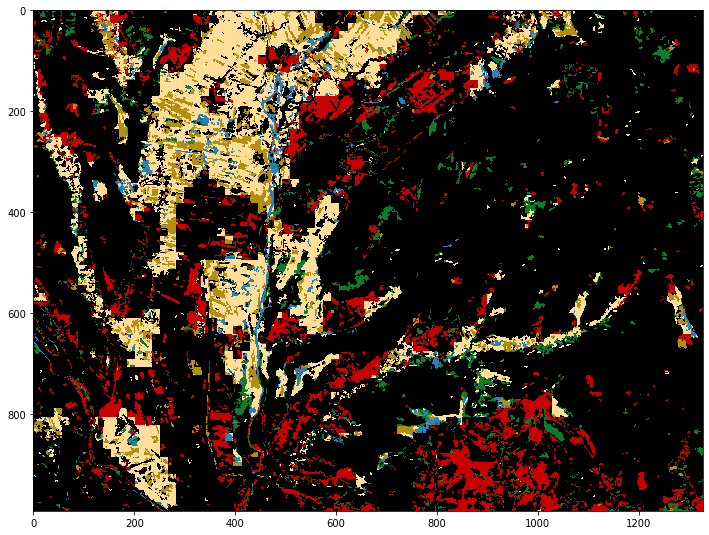

In [14]:
first_src_filepath = './diffing_data/sieve_70_2016.tif'
second_src_filepath = './diffing_data/sieve_70_2018.tif'
output_filepath='./difference.gif'

%matplotlib inline


from collections import defaultdict
import matplotlib.animation
from matplotlib.colors import ListedColormap
import matplotlib.cm
import numpy
import rasterio.features
import rasterio.plot
import rasterio.warp
    
        
def create_pixel_diff_mask(dataset, second_dataset):
    src_array = dataset.read()
    second_src_array = second_dataset.read()
    
    full_mask = None
    for i in range(len(src_array)):
        src_mask = numpy.array(src_array[i])
        second_src_mask = numpy.array(second_src_array[i])
        mask = src_mask != second_src_mask
        if full_mask is None:    
            full_mask = mask
        else:
            full_mask = full_mask | mask
                
    return full_mask

def create_color_map():
    custom = matplotlib.cm.get_cmap('viridis', 7)
    newcolors = custom(numpy.linspace(0, 1, 7))
    black = numpy.array([0/256, 0/256, 0/256, 1])
    dark_green = numpy.array([14/256, 126/256, 42/256, 1])
    green = numpy.array([116/256, 246/256, 83/256, 1])
    sand = numpy.array([255/256, 223/256, 154/256, 1])
    dark_yellow = numpy.array([179/256, 144/256, 18/256, 1])
    red = numpy.array([203/256, 0/256, 0/256, 1])
    blue = numpy.array([43/256, 131/256, 186/256, 1])
    newcolors[0, :] = black
    newcolors[1, :] = dark_green
    newcolors[2, :] = green
    newcolors[3, :] = sand
    newcolors[4, :] = dark_yellow
    newcolors[5, :] = red
    newcolors[6, :] = blue
    matplotlib.cm.register_cmap(name='custom', cmap=ListedColormap(newcolors))

with rasterio.Env():
    with rasterio.open(first_src_filepath) as src:
        with rasterio.open(second_src_filepath) as second_src:
            create_color_map()   
            # create pixel diff mask
            mask = create_pixel_diff_mask(src, second_src)
            
            # convert mask into int16
            visualization_mask = numpy.array(mask, dtype='int32')
            int16_max_value = rasterio.dtypes.dtype_ranges['int32'][1]
            visualization_mask = visualization_mask * int16_max_value
            
            # pixel diff visualization
            # rasterio.plot.show(visualization_mask, title='Pixel diff result', cmap='Greys')
            
            src_array = src.read()
            second_src_array = second_src.read()
                        
            shapes_mask = rasterio.features.shapes(visualization_mask)
  
            masked_array = second_src_array * mask
            masked_array = numpy.ma.squeeze(masked_array)
            
            # draw GIF
            plt = rasterio.plot.get_plt()
            figure = plt.figure(figsize=(12.0, 12.0))
            ims = []
            
            ims.append([plt.imshow(src_array[0],vmin=0, vmax=6, animated=True, cmap='custom')])
            ims.append([plt.imshow(second_src_array[0],vmin=0, vmax=6, animated=True, cmap='custom')])
            ims.append([plt.imshow(masked_array,vmin=0, vmax=6, animated=True, cmap='custom')])

            ani = matplotlib.animation.ArtistAnimation(figure, ims, interval=1000, blit=True, repeat_delay=1000)
            ani.save(output_filepath, writer='imagemagick', fps=1)
            